# Improving sentence embeddings with BERT and Representation Learning

In this experiment we fine-tune a BERT model to improve it's capability for encoding short texts. This yields more useful sentence representations for downstream NLP tasks.

While a vanilla BERT can be used for encoding sentences, the representations generated with it are not robust. As we can see below, the samples deemed similar by the model are often more lexically than semantically related. Small perturbations in input samples result in large changes of predicted similarity.

To improve, we use the Stanford Natural Language Inference dataset, which contains sentence pairs manually labeled with entailment, contradiction, and neutral. For these sentences we will be learning such a representation, that the similarity between the entailing pairs is greater than the similarity between the contradicting ones.

To evaluate the quality of learned embeddings we measure Pearson rank correlation on STS and SICK-R datasets.


The plan for this experiment is:
 

1.   preparing the SNLI and MNLI datasets
2.   implementing the data generator
3.   defining the loss
4.   building the model
5.   preparing the evaluation pipeling
6.   training the model


## What is in this guide?
This guide is about learning efficient sentence representations with BERT.
It contains code for building and training a sentence encoder on labeled data.
## What does it take?
For a familiar reader it should take around 90 minutes to finish this guide and train the sentence encoder. The code was tested with tensorflow==1.15.
## OK, show me the code. 
This time, most of the code from the [previous experiment ](https://medium.com/r/?url=https%3A%2F%2Ftowardsdatascience.com%2Ffine-tuning-bert-with-keras-and-tf-module-ed24ea91cff2)is reused. I recommend checking it out first. The standalone version can be found in the [repository](https://github.com/gaphex/bert_experimental/commits/master).

## Step 1: Setting up

In [1]:
import re
import os
import sys
import json
import nltk

import logging
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback

from scipy.stats import spearmanr, pearsonr
from glob import glob

nltk.download('punkt')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We begin with downloading the SNLI, MNLI, STS and SICK datasets and the pre-trained english BERT model.

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
!unzip snli_1.0.zip
!wget https://www.nyu.edu/projects/bowman/multinli/multinli_1.0.zip
!unzip multinli_1.0.zip

In [2]:
!git clone https://github.com/gaphex/bert_experimental
!git clone https://github.com/brmson/dataset-sts

sys.path.insert(0, 'bert_experimental')
sys.path.insert(0, 'dataset-sts/pysts')

from bert_experimental.finetuning.text_preprocessing import build_preprocessor
from bert_experimental.finetuning.bert_layer import BertLayer
from bert_experimental.finetuning.modeling import BertConfig, BertModel, build_bert_module

from loader import load_sts, load_sick2014

fatal: destination path 'bert_experimental' already exists and is not an empty directory.
fatal: destination path 'dataset-sts' already exists and is not an empty directory.


Define a SNLI loader function

In [0]:
from collections import Counter, defaultdict

def load_snli(fpaths):
    sa, sb, lb = [], [], []
    fpaths = np.atleast_1d(fpaths)
    for fpath in fpaths:
        with open(fpath) as fi:
            for line in fi:
                sample = json.loads(line)
                sa.append(sample['sentence1'])
                sb.append(sample['sentence2'])
                lb.append(sample['gold_label'])
    return sa, sb, lb

To handle the dataset more conveniently, we put it in a dictionary. For each unique anchor we create an ID and an entry, containing the anchor, entailment and contradiction samples. The anchors lacking at least one sample of each class are filtered out.

In [0]:
def prepare_snli(sa, sb, lb):
    
    classes = {"entailment", "contradiction"}
    anc_to_pairs = defaultdict(list)
    filtered = {}
    skipped = 0

    for xa, xb, y in zip(sa, sb, lb):
        anc_to_pairs[xa].append((xb, y))

    anchor_id = 0
    for anchor, payload in anc_to_pairs.items(): 
        
        filtered[anchor_id] = defaultdict(list)
        filtered[anchor_id]["anchor"].append(anchor)
        
        labels = set([t[1] for t in payload])
        
        if len(labels&classes) == len(classes):
            for text, label in payload:
                filtered[anchor_id][label].append(text)
            anchor_id += 1
        else:
            skipped += 1
            
    print("Loaded: {} \nSkipped: {}".format(anchor_id, skipped))
        
    return filtered

Load the SNLI and MNLI datasets.

In [5]:
train_data = ["./snli_1.0/snli_1.0_train.jsonl", "./multinli_1.0/multinli_1.0_train.jsonl"]
test_data = ["./snli_1.0/snli_1.0_test.jsonl", "./multinli_1.0/multinli_1.0_dev_matched.jsonl"]

tr_a, tr_b, tr_l = load_snli(train_data)
ts_a, ts_b, ts_l = load_snli(test_data)

fd_tr = prepare_snli(tr_a, tr_b, tr_l)
fd_ts = prepare_snli(ts_a, ts_b, ts_l)

Loaded: 277277 
Skipped: 1603
Loaded: 5853 
Skipped: 804


# Step 2: Data Generator

For training the model we will sample triplets, consisting of an anchor, a positive sample and a negative sample. To handle complex batch generation logic we use the following code:

In [0]:
class SNLIDataset:
    def __init__(self, datadict, hard_frac = 0.5, batch_size=256):
        self.datadict = datadict
        self._anchor_idx = np.array(list(self.datadict.keys()))
        self._hard_frac = hard_frac
        self._generator = self.generate_batch(batch_size)

    def generate_batch(self, size):
        while True:

            hards = int(size*self._hard_frac)
            anchor_ids = np.array(np.random.choice(self._anchor_idx, size, replace=False))

            anchors = self.get_anchors(anchor_ids)
            positives = self.get_positives(anchor_ids)
            negatives = np.hstack([self.get_hard_negatives(anchor_ids[:hards]),
                                   self.get_random_negatives(anchor_ids[hards:])])
            labels = np.ones((size,1))

            assert len(anchors) == len(positives) == len(negatives) == len(labels) == size

            yield [anchors, positives, negatives], labels
            
    def get_anchors(self, anchor_ids):
        classes = ['anchor']
        samples = self.get_samples_from_ids(anchor_ids, classes)
        return samples
    
    def get_positives(self, anchor_ids):
        classes = ['entailment']
        samples = self.get_samples_from_ids(anchor_ids, classes)
        return samples

    def get_hard_negatives(self, anchor_ids):
        classes = ['contradiction']
        samples = self.get_samples_from_ids(anchor_ids, classes)
        return samples

    def get_random_negatives(self, anchor_ids):
        samples = []
        classes = ['contradiction', 'neutral','entailment']
        for anchor_id in anchor_ids:

            other_anchor_id = self.get_random(self._anchor_idx, anchor_id)
            avail_classes = list(set(self.datadict[other_anchor_id].keys()) & set(classes))
            sample_class = self.get_random(avail_classes)
            sample = self.get_random(self.datadict[other_anchor_id][sample_class])
            samples.append(sample)
        samples = np.array(samples)
        return samples
    
    def get_samples_from_ids(self, anchor_ids, classes):
        samples = []
        for anchor_id in anchor_ids:
            sample_class = self.get_random(classes)
            sample = self.get_random(self.datadict[anchor_id][sample_class])
            samples.append(sample)
        samples = np.array(samples)
        return samples

    @staticmethod
    def get_random(seq, exc=None):
        if len(seq) == 1:
            return seq[0]
                                      
        selected = None
        while selected is None or selected == exc:
            selected = np.random.choice(seq)
        return selected

The high-level logic is contained in the generate_batch method.


1.   Batch anchor IDs are selected randomly from all available IDs.
2.   Anchor samples are retrieved from anchor samples of their IDs.
3.   Positive samples are retrieved from entailment samples of their IDs.
4.   Negative samples are retrieved from contradiction samples of their IDs.       These may be considered hard negative samples, because they are often semantically similar to their anchors. To reduce overfitting we mix them with random negative samples retrieved from other, random ID.

# Step 3: loss function

For the similarity function S we use inner product. The code for computing the approximate negative log probability of the data is below

In [0]:
def entropy_loss(vectors):
    anc, pos, neg = vectors

    pos_sim = tf.reduce_sum((anc * pos), axis=-1, keepdims=True)
    neg_mul = tf.matmul(anc, neg, transpose_b=True)
    neg_sim = tf.log(tf.reduce_sum(tf.exp(neg_mul), axis=-1, keepdims=True))

    loss = tf.nn.relu(neg_sim - pos_sim)

    return loss

# Step 4: model

We re-use the fine-tuning code from the previous experiment and build the BERT module.

In [0]:
BERT_DIR = "/content/uncased_L-12_H-768_A-12/" #@param {type:"string"}

build_bert_module(BERT_DIR+"bert_config.json",
                  BERT_DIR+"vocab.txt",
                  BERT_DIR+"bert_model.ckpt", 
                  "bert_module")

The model has three inputs for the anchor, positive and negative samples. A BERT layer with a mean pooling operation is used as a shared text encoder. Text preprocessing is handled automatically by the layer. Negative log probability loss is passed through the entropy_loss function.

For convenience, we create 3 Keras models: enc_model for encoding sentences, sim_model for computing similarity between sentence pairs and trn_model for training. All models use shared weights.

In [0]:
def dot_product(vpacks):
    u, v = tensor_pair
    return tf.reduce_sum((u * v), axis=-1, keepdims=True)

def cosine_similarity(tensor_pair):
    u, v = tensor_pair
    u = tf.math.l2_normalize(u, axis=-1)
    v = tf.math.l2_normalize(v, axis=-1)
    return tf.reduce_sum((u * v), axis=-1, keepdims=True)

def mean_loss(y_true, y_pred):
    mean_pred = tf.reduce_mean(y_pred - 0 * y_true)
    return mean_pred

def build_model(module_path, seq_len = 24, tune_lr=6, loss = entropy_loss):

    inp_anc = tf.keras.Input(shape=(1, ), dtype=tf.string, name='input_anchor')
    inp_pos = tf.keras.Input(shape=(1, ), dtype=tf.string, name='input_positive')
    inp_neg = tf.keras.Input(shape=(1, ), dtype=tf.string, name='input_negative')

    sent_encoder = BertLayer(module_path, seq_len, n_tune_layers=tune_lr, do_preprocessing=True,
                             verbose=False, pooling="mean", trainable=True, tune_embeddings=False)
    
    # magnitude multiplier to avoid NaN loss overflow
    c = 0.5
  
    anc_enc = c * sent_encoder(inp_anc) 
    pos_enc = c * sent_encoder(inp_pos) 
    neg_enc = c * sent_encoder(inp_neg) 

    loss = tf.keras.layers.Lambda(loss, name='loss')([anc_enc, pos_enc, neg_enc])
    sim = tf.keras.layers.Lambda(cosine_similarity, name='similarity')([anc_enc, pos_enc])

    trn_model = tf.keras.models.Model(inputs=[inp_anc, inp_pos, inp_neg], outputs=[loss])
    enc_model = tf.keras.models.Model(inputs=inp_anc, outputs=[anc_enc])
    sim_model = tf.keras.models.Model(inputs=[inp_anc, inp_pos], outputs=[sim])

    trn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, ),
        loss=mean_loss,
        metrics=[])

    trn_model.summary()

    mdict = {
        "enc_model": enc_model,
        "sim_model": sim_model,
        "trn_model": trn_model
    }

    return mdict

# Step 5: Evaluation pipeline

Natural Language Encoders are usually evaluated by encoding labeled sentence pairs, measuring similarity between them, then computing the correlation of that similarity with human judgement.

We will use STS 2012–2016 and SICK 2014 dataset for evaluating our model. For all sentence pairs in the test set we compute cosine similarity. We report Pearson rank correlation with human-annotated labels.

The Callback below handles the evaluation procedure and saves the provided savemodel to savepath, every time a new best result is achieved.

In [0]:
class PearsonrRankCallback(Callback):

    def __init__(self, loader, filepaths, name=None, verbose=False,
                 sim_model=None, savemodel=None, savepath=None):

        self.savemodel = savemodel
        self.savepath = savepath
        self.sim_model = sim_model
        self.loader = loader
        self.verbose = verbose
        self.name = name

        self.samples, self.labels = self.load_datasets(filepaths)
        self.best = 0
        super(PearsonrRankCallback, self).__init__()

    def load_datasets(self, filepaths):
        _xa, _xb, _y = [], [], [] 
        for filepath in filepaths:
            sa, sb, lb = self.loader(filepath)
            sa = self.join_by_whitespace(sa)
            sb = self.join_by_whitespace(sb)
            _xa += sa
            _xb += sb
            _y += list(lb)
        return [_xa, _xb], _y
            
    @staticmethod
    def join_by_whitespace(list_of_str):
        return [" ".join(s) for s in list_of_str]

    def on_epoch_begin(self, epoch, logs=None):

        pred = self.sim_model.predict(self.samples, batch_size=128, 
                                      verbose=self.verbose).reshape(-1,)
        coef, p = pearsonr(self.labels, pred)
        coef = np.round(coef, 4)
        if coef > self.best:
            self.best = coef
            print("*** New best: {} = {}".format(self.name, coef))
            if self.savemodel and self.savepath:
                self.savemodel.save_weights(self.savepath)
        else:
            print("mean: {}".format(coef))

    def on_train_end(self, logs=None):
        self.on_epoch_begin(None)

# Step 6: training the model

In [10]:
model_dict = build_model(module_path="bert_module", tune_lr=4, loss=entropy_loss)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_anchor (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_positive (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_negative (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          109482240   input_anchor[0][0]               
                                                                 input_positive[0][0]         

In [0]:
HFRAC = 0.5
BSIZE = 256

enc_model = model_dict["enc_model"]
sim_model = model_dict["sim_model"]
trn_model = model_dict["trn_model"]

tr_gen = SNLIDataset(fd_tr, hard_frac=HFRAC, batch_size=BSIZE)
ts_gen = SNLIDataset(fd_ts, hard_frac=HFRAC, batch_size=BSIZE)

spr_sts = PearsonrRankCallback(load_sts, glob("./dataset-sts/data/sts/semeval-sts/*/*test*.tsv"), name='sts',
                               sim_model=sim_model, savemodel=enc_model, savepath="encoder_en_triplet.h5")
spr_sick = PearsonrRankCallback(load_sick2014, glob("./dataset-sts/data/sts/sick2014/SICK_test_annotated.txt"), 
                                name='sick', sim_model=sim_model)

callbacks = [spr_sts, spr_sick]

In [0]:
trn_model.fit_generator(
    tr_gen._generator, validation_data=ts_gen._generator,
    steps_per_epoch=256, validation_steps=32, epochs=5, callbacks=callbacks)

*** New best: sts = 0.5481
*** New best: sick = 0.6069
Epoch 1/5
256/256 [==============================] - 361s 1s/step - loss: 0.7366 - val_loss: 0.4765
*** New best: sts = 0.7372
*** New best: sick = 0.8101
Epoch 2/5
256/256 [==============================] - 343s 1s/step - loss: 0.4185 - val_loss: 0.4005
*** New best: sts = 0.7501
*** New best: sick = 0.8209
Epoch 3/5
256/256 [==============================] - 343s 1s/step - loss: 0.3575 - val_loss: 0.3460
*** New best: sts = 0.7582
*** New best: sick = 0.8255
Epoch 4/5
256/256 [==============================] - 343s 1s/step - loss: 0.3207 - val_loss: 0.3335
*** New best: sts = 0.7595
*** New best: sick = 0.8272
Epoch 5/5
256/256 [==============================] - 342s 1s/step - loss: 0.3000 - val_loss: 0.3104
*** New best: sts = 0.7612
*** New best: sick = 0.8295


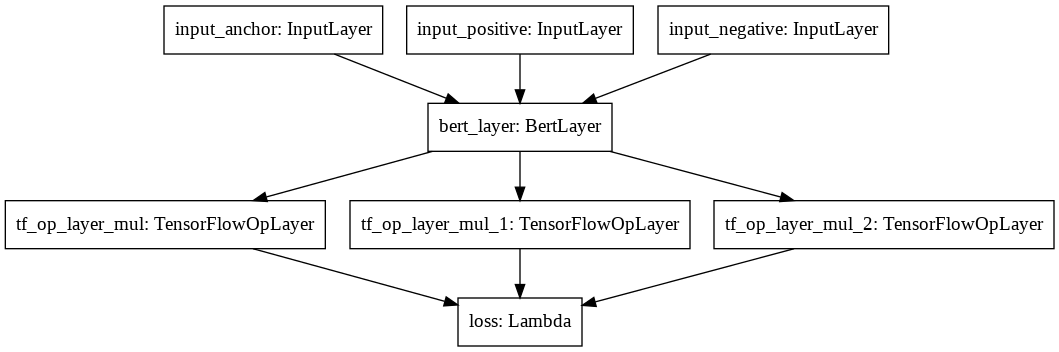

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(trn_model)

# Step 7: manual evaluation

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_similarity(labels, features1, features2, rotation):

  corr1 = compute_scores(features1)
  corr2 = compute_scores(features2)
  sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
  sns.set_context("poster")

  fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16, 8))
  fig.subplots_adjust(wspace=0.02)

  sns.set(font_scale=1.0)
  g1 = sns.heatmap(
      corr1,
      ax=ax1,
      cbar=False,
      yticklabels=labels,
      xticklabels=labels,
      vmin=np.min(corr1),
      vmax=np.max(corr1),
      cmap="Blues")
  
  g2 = sns.heatmap(
      corr2,
      ax=ax2,
      cbar=False,
      xticklabels=labels,
      vmin=np.min(corr2),
      vmax=np.max(corr2),
      cmap="Blues")
  g2.set(yticks=[])
  fig.colorbar(ax2.collections[0], ax=ax1,location="right", use_gridspec=False, pad=0.01)
  fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.01)

  g1.set_title("Base BERT")
  g2.set_title("Trained model")

def compute_scores(vectors):
  corr = np.inner(vectors, vectors)
  cmax = np.max(corr)
  corr /= cmax
  return corr

def run_and_plot(messages_, encoder1, encoder2):
  message_embeddings_1 = encoder1.predict(np.atleast_1d(messages_))
  message_embeddings_2 = encoder2.predict(np.atleast_1d(messages_))
  plot_similarity(messages_, message_embeddings_1, message_embeddings_2, 90)

def get_sents(dev_set):
  dev_keys = list(dev_set.keys())
  sents = []
  for k in np.random.choice(dev_keys, 3):
    for c in classes:
      sents.append(dev_set[k][c][0])
  return sents

In [0]:
classes = ['anchor', 'entailment', 'contradiction']
max_len = 30
dev_set = {k: v for k, v in fd_ts.items() if all([len(v[c][0]) < max_len for c in classes])}

In [16]:
#enc_model.load_weights("encoder_en.h5")

model_base_enc = build_model(module_path="bert_module", tune_lr=4, loss=entropy_loss)
base_enc_model = model_base_enc["enc_model"]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_anchor (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_positive (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_negative (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          109482240   input_anchor[0][0]               
                                                                 input_positive[0][0]       

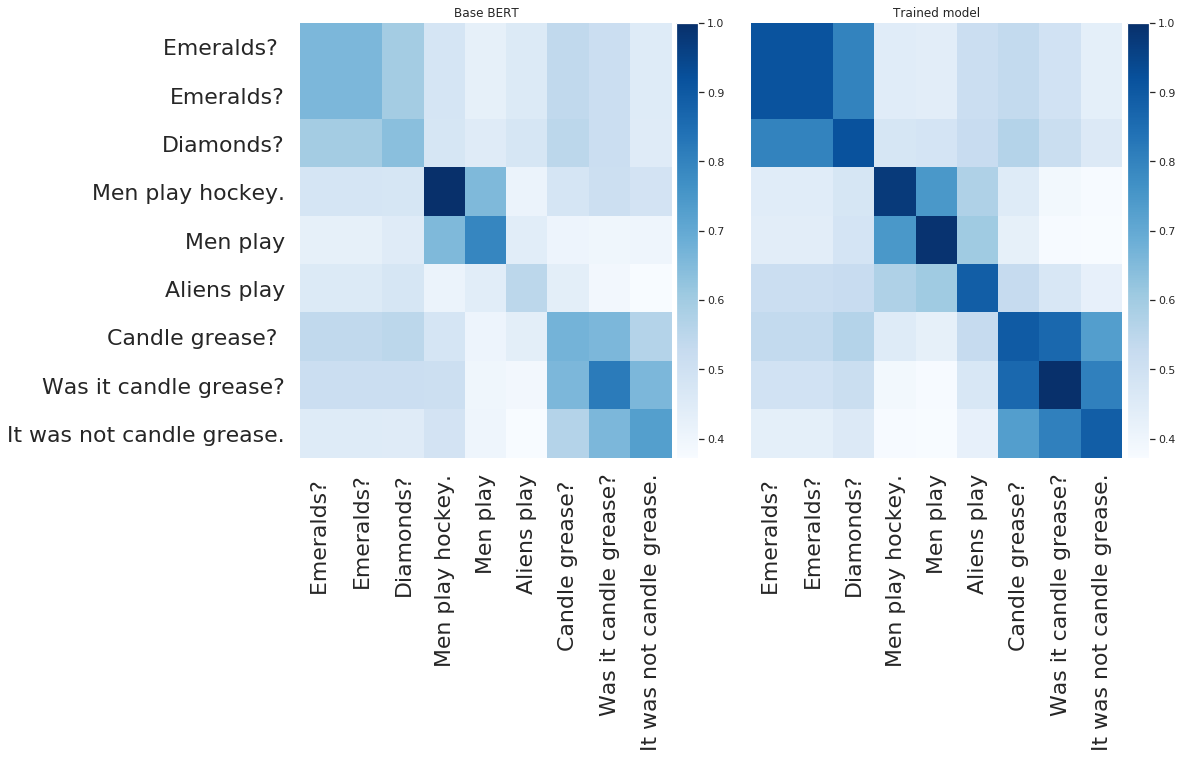

In [18]:
sents = get_sents(dev_set)
run_and_plot(sents, base_enc_model, enc_model)